In [ ]:
!pip install rapidfuzz
!pip install -q -U transformers
!pip install -q -U datasets
!pip install -q -U evaluate
!pip install -q -U tokenizers
!pip install --no-deps xformers trl peft accelerate bitsandbytes

!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you hav

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, pipeline, EarlyStoppingCallback
import os
import pandas as pd
import ast # convert stringified dictionaries to Python dicts
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re
from google.colab import drive


os.environ["WANDB_DISABLED"] = "true"

drive.mount('/content/gdrive')

# Load llama model

In [ ]:
max_seq_length = 2048 # Choose any! Llama 3 is up to 8k
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# the model that was successfully loaded is 'unsloth/llama-3-8b-bnb-4bit'. This model is designed for causal langauge modeling (predicting the next token given previous ones)
model, tokenizer = FastLanguageModel.from_pretrained(
    # "meta-llama/Llama-4-Maverick-17B-128E-Original", # does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.
    # model_name = "unsloth/Llama-4-Maverick-17B-128E", # Can't load safetensors
    # model_name = 'unsloth/Llama-3.3-70B-Instruct-GGUF', # does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.
    # model_name = 'meta-llama/Llama-3.3-70B-Instruct', # Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. 'llm_int8_enable_fp32_cpu_offload'
    model_name = 'unsloth/llama-3-8b-bnb-4bit',
    # model_name = 'unsloth/Llama-3.3-70B-Instruct-bnb-4bit',
    # model_name = 'unsloth/Llama-3.2-1B-Instruct',
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto", # Automatically determine device mapping
)

==((====))==  Unsloth 2025.7.7: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

# Configuring LoRA (low-rank adaptation) into our model, which allows us to efficiently update just a fraction of the model's parameters, enhancing training speed and reducing computational load.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Low-rank dimension, suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Model parameters approximated through LoRA.
    lora_alpha = 16, # Numerator for scaling factor for delta(W)
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

Unsloth 2025.7.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Create and format fine-tuning prompt for LFUD+Logic Dataset

In [ ]:

# from datasets import Dataset

# # Convert to HuggingFace Dataset with only the 'text' column
# dataset = Dataset.from_pandas(df[['text']])

# # Tokenize the dataset
# tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512), batched=True)

data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

lfud_logic_train_df = pd.read_csv(f'{data_root_path}/lfud_logic_train.csv').drop(columns = 'label')
lfud_logic_val_df = pd.read_csv(f'{data_root_path}/lfud_logic_val.csv').drop(columns = 'label')

# Format prompt text for fine-tuning
lfud_logic_train_df['text'] = lfud_logic_train_df.apply(
    lambda row: f"Classify the logical fallacy in this sentence:\nSentence: {row['input']}\nFallacy: {row['output']}",
    axis=1
)

lfud_logic_val_df['text'] = lfud_logic_val_df.apply(
    lambda row: f"Classify the logical fallacy in this sentence:\nSentence: {row['input']}\nFallacy: {row['output']}",
    axis=1
)

# Convert to HuggingFace Dataset
train_dataset_raw = Dataset.from_pandas(lfud_logic_train_df[['text']])
eval_dataset_raw = Dataset.from_pandas(lfud_logic_val_df[['text']])

# Tokenize
tokenized_train_dataset = train_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)
tokenized_eval_dataset = eval_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)

Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [ ]:
# Define training args
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps", # Add evaluation strategy to compute metrics
        eval_steps=10, # Evaluate every 10 steps
        metric_for_best_model="eval_loss", # Specify the metric to monitor for early stopping
        load_best_model_at_end=True, # Load the best model when training ends
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Start the actual training
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,240 | Num Epochs = 1 | Total steps = 405
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,8.540900,7.986900
20,5.888700,5.777653
30,5.542400,5.562125
40,5.537400,5.533809
50,5.388900,5.518041
60,5.418800,5.514104
70,5.482000,5.511979
80,5.445000,5.511041
90,5.439700,5.510468
100,5.496600,5.509064


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Save llama model

In [ ]:
# Save unsloth/llama-3-8b-bnb-4bit
llama_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/llama_model'
model.save_pretrained(llama_model_checkpoint_filepath)

# Load model to use again

In [ ]:
llama_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/llama_model'
model, tokenizer = FastLanguageModel.from_pretrained(llama_model_checkpoint_filepath)

==((====))==  Unsloth 2025.7.7: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Unsloth 2025.7.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Load LogicClimate dataset for inference

In [ ]:
# Load LogicClimate dataset for inference
logic_climate_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('intentional', 'intentional fallacy')

# Drop Equivocation fallacies from LogicClimate dataset

  [Li et al. (2024)](https://aclanthology.org/2024.findings-naacl.192.pdf): due to the rather vague definition of Equivocation pro vided by Jin et al. (2022), and the scarcity of such fallacy instances in real life, GPT-4 can hardly un derstand Equivocation and generate correspond ing sentences correctly. To ensure the quality of the sentences generated by GPT-4 , we neglected Equivocation fallacy type and generated the sen tences for the rest twelve logical fallacy types.


In [ ]:
# Drop Equivocation
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

# Map fallacy of logic to deductive fallacy.

[Li et al. (2024)](https://aclanthology.org/2024.findings-naacl.192.pdf) LFUD dataset: **Deductive fallacies** occur when there is a logical flaw in the reasoning behind the argument, such as Affirming the consequent, Denying the antecedent, Affirming a disjunct and so on.

According to [mappings.csv](https://github.com/causalNLP/logical-fallacy/blob/main/data/mappings.csv), **Fallacy of logic** is also known as a logical error, which is an error in the logical structure of an argument. For example, If A is true, then B is true. B is true. Therefore, A is true. (This is known as Affirming the consequent, and falls under the umbrella of deductive fallacy)

In [ ]:
# Map fallacy of logic label to deductive fallacy
logic_climate_all.loc[:, 'logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('fallacy of logic', 'deductive fallacy')

# Assert fallacy labels between LFUD+Logic and LogicClimate datasets are the same
set(lfud_logic_train_df['output'].unique()) == set(logic_climate_all['logical_fallacies'].unique())

# Generate fallacy type predictions on LogicClimate

In [ ]:
def make_prompt(sentence):
    return (f"""Classify the logical fallacy in this sentence:
        Sentence: {sentence}
        Fallacy:""")

# Ensure max_new_tokens is short so it doesn’t generate extra
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=15,
    return_full_text=False,
)

def classify_fallacy(text):
    prompt = make_prompt(text)
    output = pipe(prompt)[0]['generated_text'].strip()
    # Optionally clean or truncate if model generates extra
    return output.split('\n')[0].strip()  # only take first line

logic_climate_all['predicted_fallacy'] = logic_climate_all['source_article'].apply(classify_fallacy)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'
logic_climate_all.to_csv(f'{data_root_path}/logic_climate_predictions.csv', index = False)

# Load LogicClimate predictions again

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

logic_climate_all = pd.read_csv(f'{data_root_path}/logic_climate_predictions.csv')

# Fuzzy match model predictions to the 12 labels

In [ ]:
valid_labels = logic_climate_all['logical_fallacies'].unique()

def clean_text(text):
    # Remove non-letter characters (keep spaces), lowercase, and trim
    return re.sub(r'[^a-zA-Z\s]', '', text).strip().lower()

def normalize_prediction(pred, valid_labels, threshold=80):
    pred_clean = clean_text(pred)
    match, score, _ = process.extractOne(
        pred_clean, valid_labels, scorer=fuzz.token_sort_ratio
    )
    return match if score >= threshold else pred_clean

# Normalize predictions
logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['predicted_fallacy'].apply(
    lambda x: normalize_prediction(x, valid_labels)
)

logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['normalized_fallacy_predictions'].str.replace('ad populumnnldnda', 'ad populum')

In [ ]:
logic_climate_all['normalized_fallacy_predictions'].unique()

array(['appeal to emotion', 'faulty generalization', 'false dilemma',
       'ad populum', 'fallacy of credibility', 'false causality',
       'fallacy of relevance', 'intentional fallacy', 'deductive fallacy',
       'fallacy of extension', 'circular reasoning', 'ad hominem'],
      dtype=object)

# Evaluation reporting

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 0.2086

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.3167    0.1979    0.2436        96
            ad populum     0.0531    0.0952    0.0682        63
     appeal to emotion     0.3917    0.3333    0.3602       141
    circular reasoning     0.0588    0.2857    0.0976         7
     deductive fallacy     0.0562    0.0568    0.0565        88
fallacy of credibility     0.2320    0.3435    0.2769       131
  fallacy of extension     0.1622    0.1875    0.1739        64
  fallacy of relevance     0.1176    0.1942    0.1465       103
       false causality     0.1839    0.2192    0.2000        73
         false dilemma     0.3125    0.1020    0.1538        49
 faulty generalization     0.1341    0.1805    0.1538       133
   intentional fallacy     0.4497    0.1988    0.2757       337

              accuracy                         0.2086      1285
             macro avg     0.2057    0.1996    0.1839      12

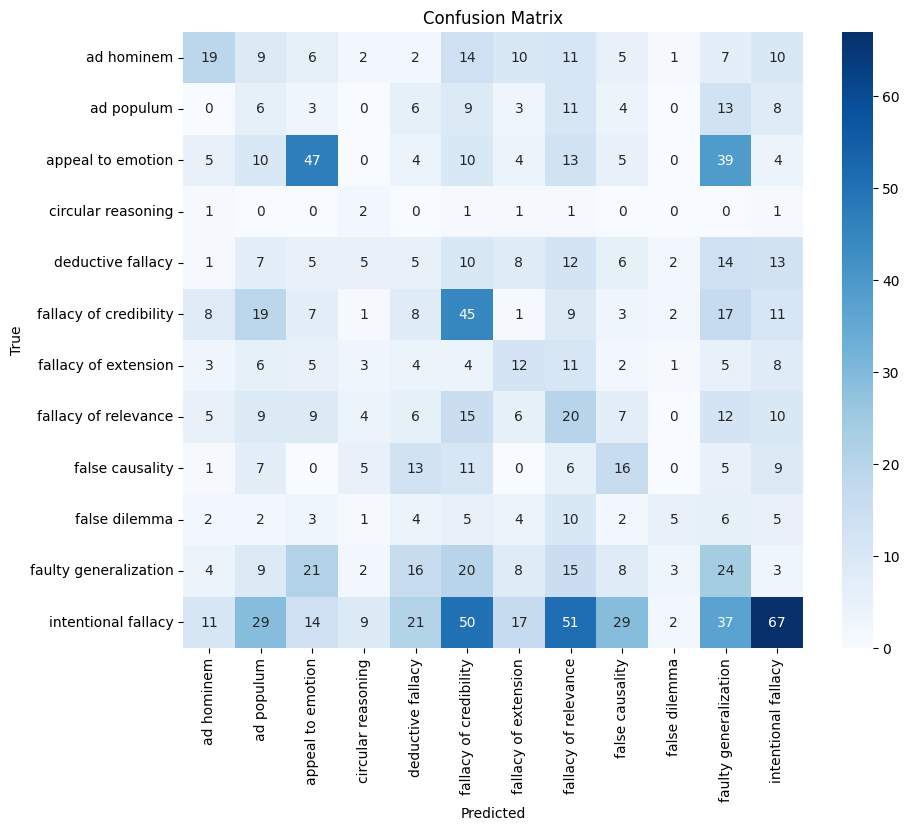

In [ ]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['normalized_fallacy_predictions'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

lfud_logic_train_df = pd.read_csv(f'{data_root_path}/lfud_logic_train.csv').drop(columns = 'label')
lfud_logic_train_df

,input,output
0,All flowers don't stay open forever. Roses are...,faulty generalization
1,"When I stop looking at them, the flowers close...",false causality
2,Flowers do not bloom perennially because all f...,circular reasoning
3,Most people think that all flowers don't stay ...,ad populum
4,"""All flowers either perish eventually or they ...",false dilemma
...,...,...
3235,Either we accept the findings of this study de...,false dilemma
3236,J: Cats are better than dogs.\nV: Dogs are bet...,ad hominem
3237,"I was assigned a personal trainer at the Rec, ...",ad hominem
3238,We have pure food and drug laws; why can't we ...,deductive fallacy


In [ ]:
lfud_logic_train_df.head().to_dict(orient = 'list')

{'input': ["All flowers don't stay open forever. Roses are a type of plants. Therefore, all plants do not stay open forever.",
  "When I stop looking at them, the flowers close. Therefore, the flowers withered because I didn't look at them.",
  "Flowers do not bloom perennially because all flowers don't stay open forever.",
  "Most people think that all flowers don't stay open forever, therefore it must be true.",
  '"All flowers either perish eventually or they must not be legitimate flowers."'],
 'output': ['faulty generalization',
  'false causality',
  'circular reasoning',
  'ad populum',
  'false dilemma']}